In [2]:

import torch
import torch.nn as nn
import timm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


import sys
sys.path.append('../DataLoader')

from dataloader_fits import SunImageDataset

from lightning.fabric import Fabric

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

import scipy.stats as stats

import datetime

In [3]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch()
print(fabric.device)

Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0


In [4]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
# hidden_size = 100
num_epochs = 10
batch_size = 2
learning_rate = 0.001
dropout = 0.5

k_folds = 5

In [5]:
dataset = SunImageDataset(csv_file="D:\\New folder (2)\\dataset_full_7days.csv", offset=0)

total_size = len(dataset)
fold_size = total_size // k_folds
indices = list(range(total_size))

k_fold_1_indices = indices[:fold_size]
k_fold_2_indices = indices[fold_size:2*fold_size]
k_fold_3_indices = indices[2*fold_size:3*fold_size]
k_fold_4_indices = indices[3*fold_size:4*fold_size]
k_fold_5_indices = indices[4*fold_size:]

print(len(k_fold_1_indices))
print(len(k_fold_2_indices))
print(len(k_fold_3_indices))
print(len(k_fold_4_indices))
print(len(k_fold_5_indices))

dataloaders = [k_fold_1_indices, k_fold_2_indices, k_fold_3_indices, k_fold_4_indices, k_fold_5_indices]

# Get date list 
kp_dates = pd.read_csv("D:\\New folder (2)\\matched_kp_dates_full_7days.csv")
kp_dates_list = kp_dates["date"].tolist() 

1097
1097
1097
1097
1099


In [6]:
# Get active indices
dataset_csv_file = pd.read_csv("D:\\New folder (2)\\dataset_full_7days.csv")
active_indices = []

for i in dataset_csv_file.index:
    if dataset_csv_file['Kp'][i] >= 3.667:
        active_indices.append(i)
        
active_dataloaders = []
for dataloader in dataloaders:
    active_dataloaders.append(list(set(dataloader) & set(active_indices)))
    
for dataloader in active_dataloaders:
    print(len(dataloader))

290
287
388
452
324


In [7]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()
        
        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)
        
        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )
        
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_size*10, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
        )
    
    def forward(self, images) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """
        
        batch_size = images.shape[0]
        
        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, -1)
        
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# model, optimizer = fabric.setup(model, optimizer)
model.train()

GmiSwinTransformer(
  (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pretrained_model): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, elementwi

In [8]:
torch.cuda.empty_cache()

In [9]:
def calculate_rates(all_outputs, all_labels):
    storm_labels = []
    for output in all_labels:
        if output < 3.667:
            storm_labels.append(0)
        else:
            storm_labels.append(1)
    storm_outputs = []
    for output in all_outputs:
        if output < 3.667:
            storm_outputs.append(0)
        else:
            storm_outputs.append(1)

    # Calculate true positive, true negative, false positive, false negative
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(storm_labels)):
        if storm_labels[i] == 1 and storm_outputs[i] == 1:
            tp += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 0:
            tn += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 1:
            fp += 1
        elif storm_labels[i] == 1 and storm_outputs[i] == 0:
            fn += 1
            
    return tp, tn, fp, fn


def true_skill_score(tp, tn, fp, fn):  
            
    # Calculate true skill score
    tss = (tp / (tp + fp)) - (fp / (fp + tn)) if ((tp > 0 and tn > 0) or fp > 0) else 0
    return tss
    
def calculate_metrics(tp, tn, fp, fn):
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    
    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return accuracy, precision, recall, f1





FOLD 1
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.419334885587103


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  3.290713510145573


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.8708682565527686


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.007315764384029


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.319006632218097


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.4025275192834403


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.9234929331484439


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.3567761504296016


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7137049787094555


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.656930044358821


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5731232237973879


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.5065298591857545


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.446998573204833


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.517852210516928


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3820033937754836


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.604440130049512


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.31379122575406876


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.563660412099304


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.27618845259933306


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.4651308202798408


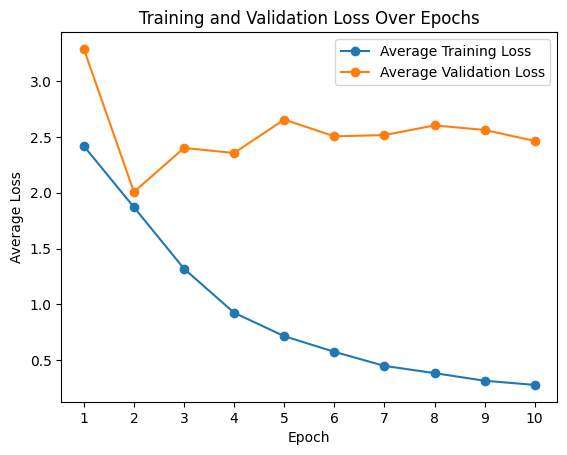

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.4651
RMSE: 1.5701
MSE: 2.4674
MAE: 1.2735
R²: -0.3163
R: -0.0065
True Skill Score: 0.0293
Accuracy: 0.6299
Precision: 0.2387
Recall: 0.1828
F1 Score: 0.2070


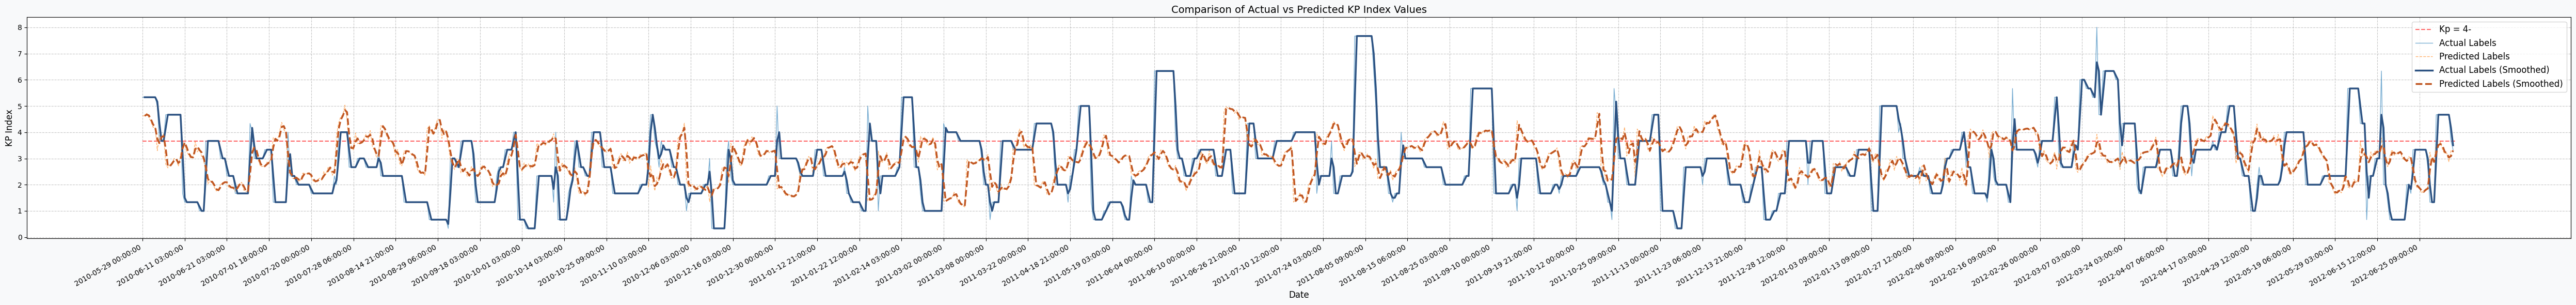

[4.625, 4.625, 4.71875, 4.5625, 4.40625, 4.1875, 4.1875, 3.296875, 3.875, 3.765625, 3.9375, 2.78125, 2.640625, 2.765625, 2.84375, 3.0, 2.953125, 2.703125, 3.109375, 3.65625, 3.5625, 3.265625, 3.109375, 3.0, 3.078125, 3.640625, 3.25, 3.390625, 3.078125, 2.953125, 2.421875, 2.03125, 2.15625, 2.078125, 1.90625, 1.7578125, 1.8203125, 2.0, 2.078125, 2.109375, 2.078125, 1.8671875, 1.921875, 1.8515625, 1.75, 1.984375, 2.015625, 2.09375, 1.7890625, 1.75, 1.734375, 3.125, 3.3125, 3.5, 3.15625, 2.90625, 2.6875, 2.703125, 2.703125, 2.859375, 2.828125, 3.03125, 3.796875, 3.703125, 3.65625, 4.03125, 4.375, 4.09375, 3.984375, 2.4375, 2.46875, 2.25, 2.234375, 2.296875, 2.109375, 2.1875, 2.4375, 2.4375, 2.40625, 2.453125, 2.28125, 2.140625, 2.109375, 2.1875, 2.25, 2.171875, 2.5, 2.390625, 2.65625, 2.65625, 2.359375, 2.546875, 3.890625, 4.34375, 4.59375, 4.65625, 5.03125, 4.5, 3.3125, 3.484375, 3.3125, 3.96875, 3.5625, 3.59375, 3.625, 3.75, 3.921875, 3.734375, 4.0625, 3.453125, 3.3125, 3.046875, 3.1406

Testing Progress:   0%|          | 0/145 [00:00<?, ?it/s]

Average test loss: 4.1376
RMSE: 2.0341
MSE: 4.1376
MAE: 1.7356
R²: -3.0308
R: 0.2338


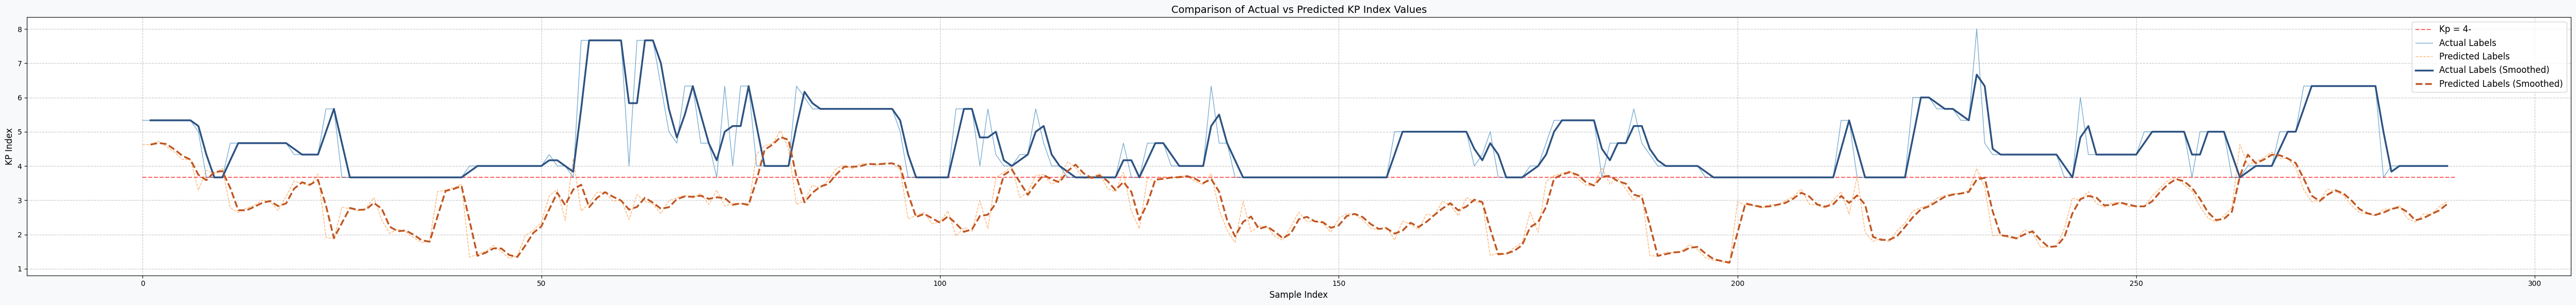

[4.625, 4.625, 4.71875, 4.5625, 4.40625, 4.1875, 4.1875, 3.296875, 3.875, 3.765625, 3.9375, 2.78125, 2.640625, 2.765625, 2.84375, 3.0, 2.953125, 2.703125, 3.109375, 3.5625, 3.484375, 3.421875, 3.765625, 1.9140625, 1.875, 2.796875, 2.75, 2.6875, 2.765625, 3.078125, 2.421875, 2.03125, 2.15625, 2.078125, 1.90625, 1.7578125, 1.8203125, 3.25, 3.296875, 3.359375, 3.46875, 1.3359375, 1.421875, 1.5078125, 1.6796875, 1.5, 1.296875, 1.390625, 1.96875, 2.125, 2.34375, 3.125, 3.3125, 2.40625, 4.21875, 2.6875, 2.90625, 3.234375, 3.234375, 2.96875, 3.015625, 2.4375, 3.171875, 2.96875, 2.890625, 2.609375, 2.984375, 3.078125, 3.140625, 3.0625, 3.203125, 2.875, 3.296875, 2.828125, 2.90625, 2.90625, 2.828125, 4.34375, 4.59375, 4.65625, 5.03125, 4.5, 2.875, 3.0, 3.4375, 3.359375, 3.59375, 3.921875, 4.03125, 3.921875, 4.0625, 4.0625, 4.03125, 4.09375, 4.0625, 3.90625, 2.453125, 2.5625, 2.640625, 2.3125, 2.375, 2.6875, 1.953125, 2.203125, 2.09375, 2.984375, 2.171875, 3.65625, 3.8125, 3.984375, 3.078125, 3.

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.3394443560250586


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0899992880431006


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.806599363951163


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.443570136997738


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.3002080337734467


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  4.633814545418051


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.9542685851165553


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  3.5644320777917655


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7264623673387182


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.374088990486898


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5597741010855403


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.4847628719322654


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4579087214847453


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.5938354733608704


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.39438758169846866


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.518198018858293


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3450612201106391


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.5785235662059094


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3004852402143436


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.7764015728824063


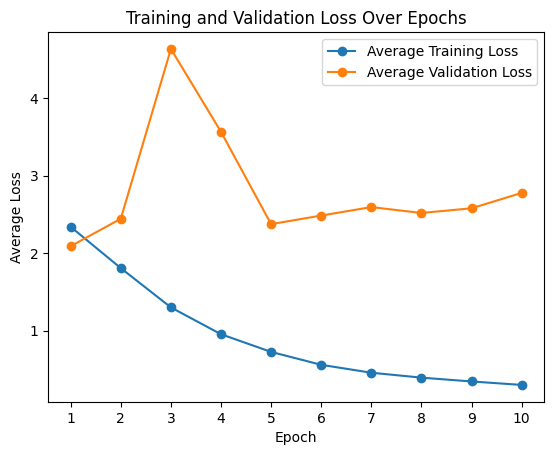

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.7764
RMSE: 1.6663
MSE: 2.7788
MAE: 1.3642
R²: -0.3570
R: 0.0502
True Skill Score: -0.0522
Accuracy: 0.5907
Precision: 0.2404
Recall: 0.2613
F1 Score: 0.2504


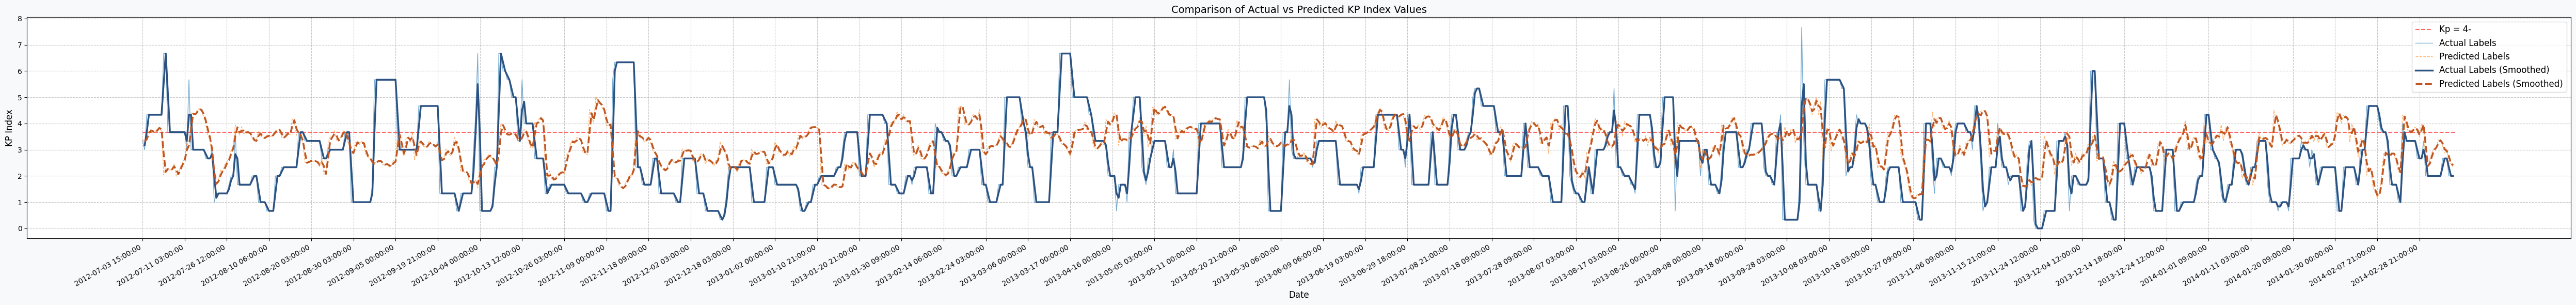

[3.40625, 3.25, 3.53125, 3.703125, 3.765625, 3.640625, 3.671875, 3.796875, 3.859375, 3.703125, 2.03125, 2.28125, 2.25, 2.21875, 2.28125, 2.453125, 1.9921875, 2.140625, 2.359375, 2.5, 2.6875, 3.28125, 3.046875, 4.40625, 4.34375, 4.34375, 4.53125, 4.5625, 4.46875, 4.25, 3.96875, 3.5625, 3.359375, 2.671875, 1.640625, 1.7578125, 1.8203125, 2.21875, 2.15625, 2.421875, 2.53125, 2.671875, 2.984375, 3.109375, 3.9375, 3.765625, 3.5625, 3.875, 3.59375, 3.703125, 3.640625, 3.625, 3.4375, 3.3125, 3.359375, 3.703125, 3.53125, 3.46875, 3.421875, 3.578125, 3.484375, 3.5, 3.609375, 3.71875, 3.75, 3.765625, 3.46875, 3.4375, 3.609375, 3.609375, 3.578125, 4.1875, 4.0625, 3.546875, 3.71875, 3.40625, 3.3125, 2.515625, 2.484375, 2.578125, 2.578125, 2.53125, 2.59375, 2.484375, 2.359375, 2.6875, 2.0625, 2.09375, 3.203125, 3.484375, 3.46875, 3.734375, 3.359375, 3.34375, 3.484375, 3.71875, 3.6875, 3.390625, 3.171875, 2.84375, 2.890625, 3.296875, 3.265625, 3.1875, 3.34375, 3.15625, 2.78125, 2.71875, 2.625, 2.468

Testing Progress:   0%|          | 0/144 [00:00<?, ?it/s]

Average test loss: 3.3105
RMSE: 1.8195
MSE: 3.2772
MAE: 1.4181
R²: -3.4475
R: -0.1776


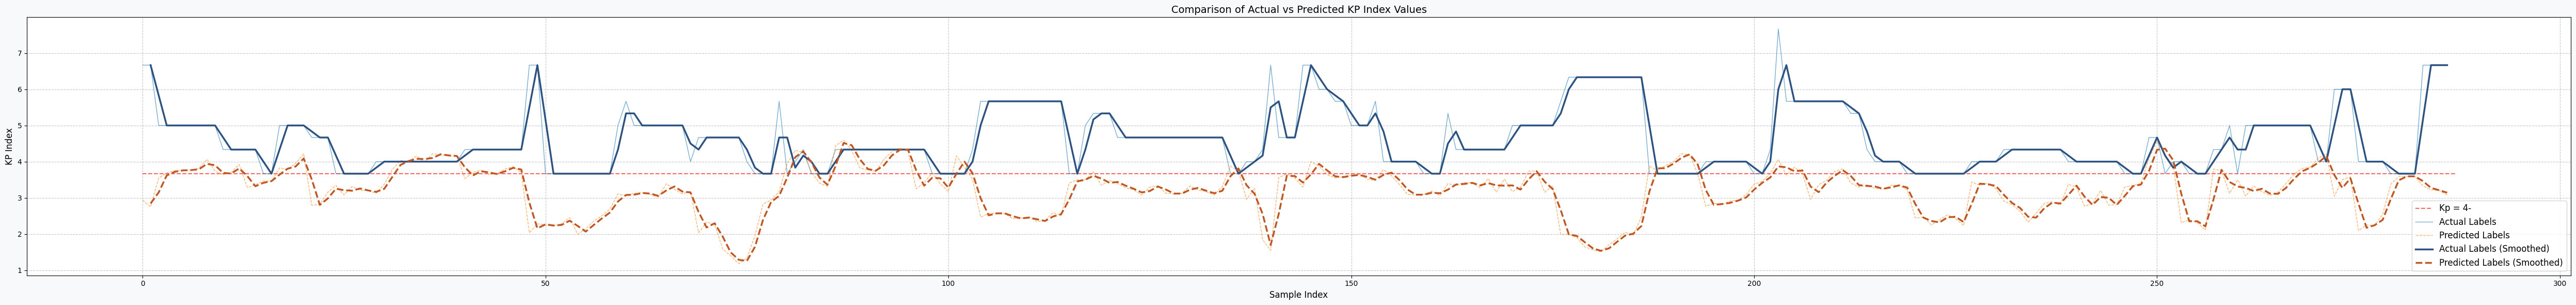

[2.9375, 2.75, 3.546875, 3.6875, 3.75, 3.765625, 3.765625, 3.8125, 4.0625, 3.734375, 3.640625, 3.703125, 3.921875, 3.28125, 3.359375, 3.46875, 3.453125, 3.828125, 3.78125, 3.953125, 4.21875, 2.796875, 2.8125, 3.15625, 3.34375, 3.078125, 3.3125, 3.203125, 3.203125, 3.125, 3.375, 3.78125, 4.03125, 4.0, 4.15625, 3.984375, 4.21875, 4.1875, 4.15625, 4.15625, 3.53125, 3.703125, 3.765625, 3.640625, 3.671875, 3.796875, 3.859375, 3.703125, 2.03125, 2.28125, 2.25, 2.21875, 2.28125, 2.453125, 1.9921875, 2.140625, 2.359375, 2.5, 2.6875, 3.109375, 3.046875, 3.125, 3.140625, 3.09375, 3.015625, 3.390625, 3.234375, 3.109375, 3.1875, 2.03125, 2.328125, 2.265625, 1.5859375, 1.390625, 1.1796875, 1.3359375, 1.953125, 2.828125, 2.9375, 3.171875, 3.9375, 4.3125, 4.25, 3.71875, 3.40625, 3.3125, 4.4375, 4.59375, 4.3125, 3.828125, 3.765625, 3.734375, 4.0625, 4.28125, 4.375, 4.28125, 3.25, 3.421875, 3.6875, 3.390625, 3.171875, 4.15625, 3.84375, 3.515625, 2.46875, 2.5625, 2.578125, 2.5625, 2.421875, 2.4375, 2.46

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.443947492621241


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.278442610063054


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.0180787347805005


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0420078384485265


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.637015768067258


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.181899832054707


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.115827406835525


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.5691194127963644


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7667332601965143


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.5483649353669975


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5884829624525376


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.5599470035674923


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.44381604278605996


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.7490271815587173


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3663491182698602


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.4980106133130464


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.29700037656684364


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.5276286940371113


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.2749375217433373


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.716649442664428


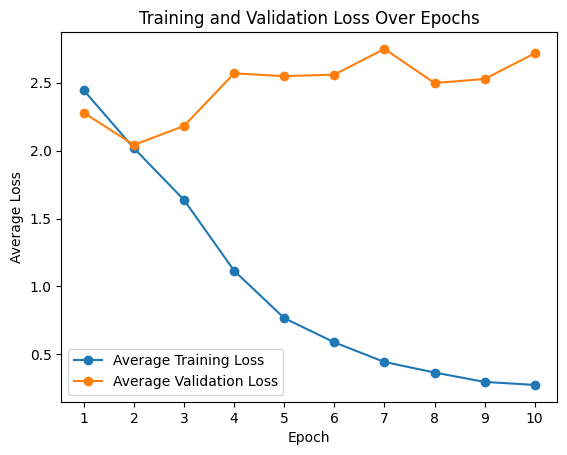

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.7166
RMSE: 1.6482
MSE: 2.7191
MAE: 1.2822
R²: -0.3930
R: 0.0397
True Skill Score: 0.2274
Accuracy: 0.6217
Precision: 0.2923
Recall: 0.0490
F1 Score: 0.0839


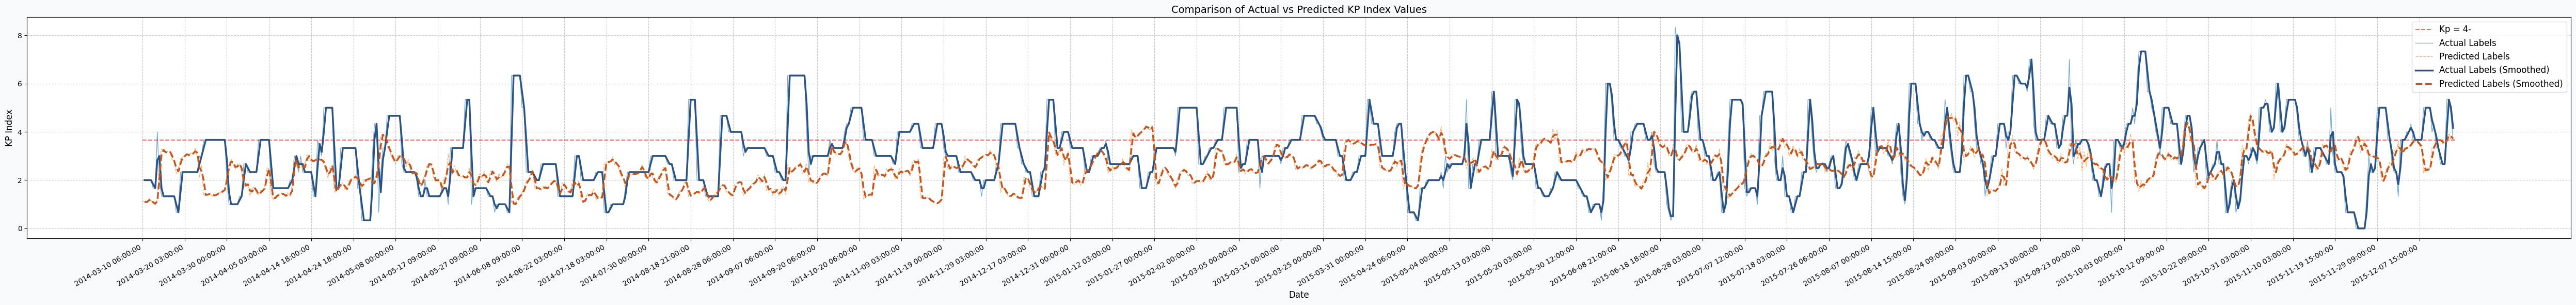

[1.125, 1.09375, 1.078125, 1.234375, 1.1640625, 1.0078125, 1.03125, 1.2265625, 2.84375, 3.296875, 3.203125, 3.109375, 3.203125, 3.171875, 2.859375, 2.75, 2.265625, 2.453125, 2.90625, 2.953125, 3.03125, 3.109375, 2.984375, 3.15625, 3.046875, 3.34375, 2.921875, 2.125, 2.625, 1.359375, 1.40625, 1.3984375, 1.4609375, 1.3359375, 1.390625, 1.3828125, 1.5, 1.4609375, 1.59375, 1.59375, 2.34375, 2.6875, 2.859375, 2.640625, 2.453125, 2.671875, 2.671875, 2.328125, 1.6640625, 1.8828125, 1.7734375, 1.359375, 1.6875, 1.703125, 1.4609375, 1.375, 1.5859375, 1.5390625, 1.7734375, 2.5, 2.46875, 1.359375, 1.171875, 1.34375, 1.3671875, 1.4296875, 1.453125, 1.375, 1.328125, 1.4921875, 1.3203125, 1.8125, 3.03125, 2.640625, 2.40625, 2.78125, 2.375, 2.6875, 3.046875, 2.953125, 2.75, 2.8125, 2.84375, 2.921875, 2.796875, 2.875, 2.640625, 2.40625, 2.09375, 2.5625, 2.640625, 1.4765625, 1.5546875, 1.8046875, 1.7890625, 1.8984375, 1.6015625, 1.65625, 1.9921875, 2.046875, 2.046875, 2.234375, 1.9296875, 1.90625, 1.61

Testing Progress:   0%|          | 0/194 [00:00<?, ?it/s]

Average test loss: 5.4409
RMSE: 2.3326
MSE: 5.4409
MAE: 2.0272
R²: -5.5356
R: -0.0104


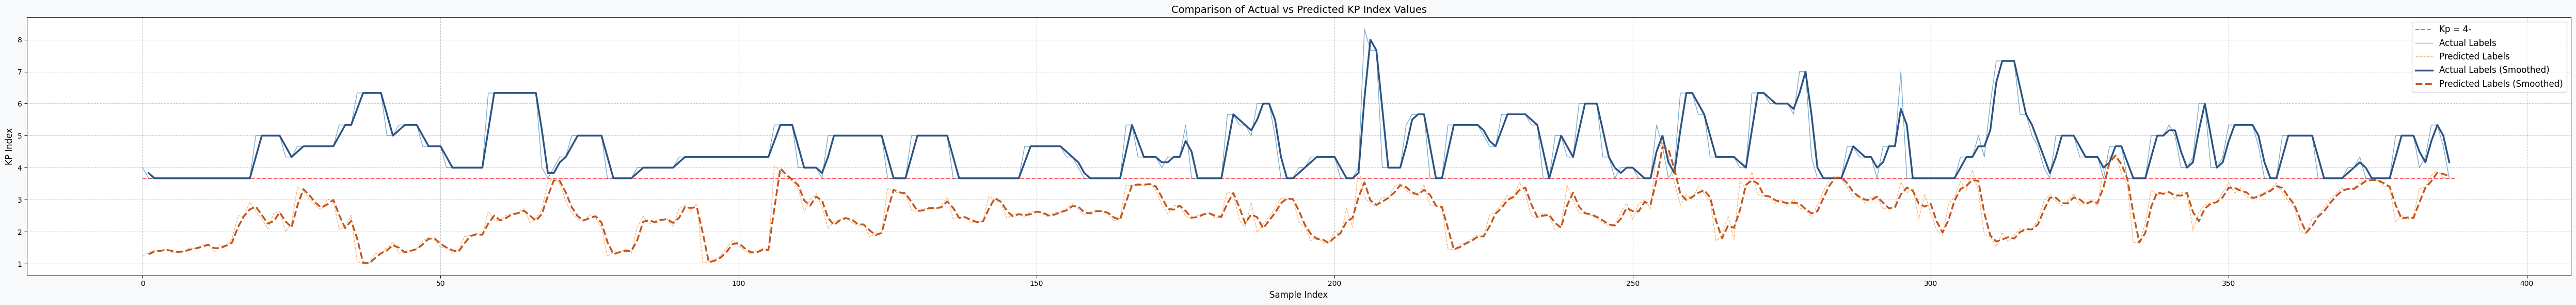

[1.2265625, 1.359375, 1.40625, 1.3984375, 1.4609375, 1.3359375, 1.390625, 1.3828125, 1.5, 1.4609375, 1.59375, 1.59375, 1.375, 1.5859375, 1.5390625, 1.7734375, 2.5, 2.46875, 2.921875, 2.640625, 2.40625, 2.09375, 2.5625, 2.640625, 2.0, 2.265625, 3.390625, 3.265625, 3.0, 2.8125, 2.6875, 3.015625, 2.96875, 2.0625, 2.15625, 2.515625, 1.0625, 1.0, 1.0234375, 1.3125, 1.3359375, 1.484375, 1.6796875, 1.3203125, 1.3828125, 1.421875, 1.484375, 1.71875, 1.8359375, 1.734375, 1.5078125, 1.5, 1.328125, 1.421875, 1.84375, 1.8828125, 1.9453125, 1.8671875, 2.640625, 2.359375, 2.34375, 2.515625, 2.5625, 2.59375, 2.71875, 2.28125, 2.40625, 2.703125, 3.53125, 3.671875, 3.5, 2.953125, 2.578125, 2.390625, 2.3125, 2.53125, 2.4375, 2.125, 1.21875, 1.375, 1.34375, 1.4609375, 1.328125, 2.140625, 2.484375, 2.234375, 2.34375, 2.390625, 2.390625, 2.15625, 2.703125, 2.828125, 2.65625, 2.875, 1.03125, 1.0546875, 1.1328125, 1.25, 1.4921875, 1.734375, 1.5546875, 1.4140625, 1.3046875, 1.3828125, 1.4765625, 1.390625, 4.0

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.3103962127210527


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.627311502302896


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.9516126223923485


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1722351011537264


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.5308267683063497


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2888136676127577


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.3100302238598867


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.4957196559309147


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.8789453408186555


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.3346000160673763


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.643845762474439


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1580227638021423


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5135527164378291


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1993178969053724


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4145071715327454


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1285342553519992


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3521702104782848


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1890278496942357


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.31089922974123735


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1808757962144143


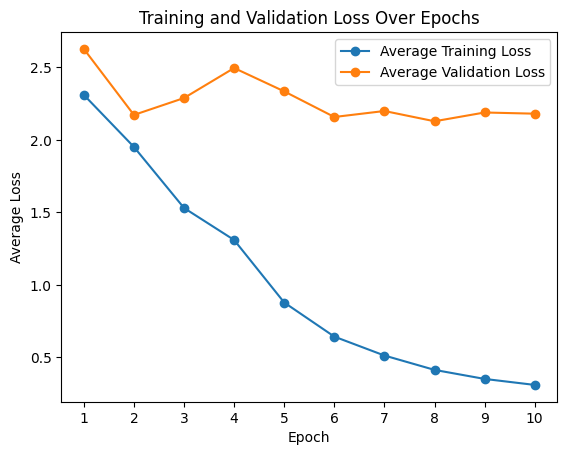

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.1809
RMSE: 1.4768
MSE: 2.1826
MAE: 1.1833
R²: -0.1721
R: 0.1280
True Skill Score: 0.1898
Accuracy: 0.5579
Precision: 0.4441
Recall: 0.2898
F1 Score: 0.3507


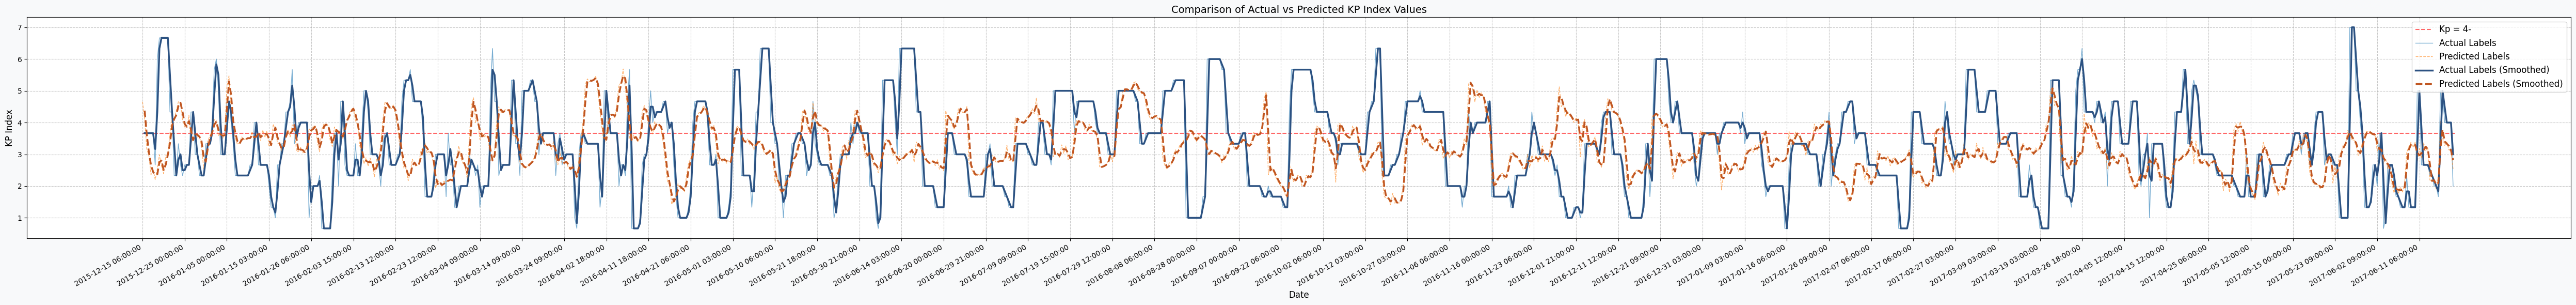

[4.65625, 4.09375, 3.171875, 2.96875, 2.359375, 2.53125, 2.203125, 2.53125, 2.984375, 2.625, 2.390625, 2.953125, 3.015625, 3.671875, 4.125, 4.09375, 4.375, 4.65625, 4.59375, 4.0625, 3.859375, 3.875, 4.21875, 3.328125, 3.5625, 3.6875, 3.546875, 3.5625, 3.25, 2.546875, 2.984375, 3.4375, 3.578125, 3.765625, 4.09375, 3.96875, 3.578125, 3.6875, 3.484375, 3.71875, 5.125, 5.46875, 4.28125, 3.84375, 3.515625, 3.3125, 3.359375, 3.546875, 3.46875, 3.484375, 3.53125, 3.484375, 3.71875, 3.359375, 3.75, 3.640625, 3.4375, 3.765625, 3.53125, 3.734375, 3.25, 3.328125, 3.953125, 3.734375, 3.359375, 3.3125, 3.046875, 3.40625, 3.6875, 3.765625, 3.546875, 3.921875, 3.921875, 3.09375, 3.09375, 3.21875, 3.046875, 3.09375, 3.265625, 3.8125, 3.703125, 3.890625, 3.890625, 3.359375, 3.078125, 3.78125, 3.953125, 3.921875, 3.90625, 3.4375, 3.25, 3.859375, 3.671875, 3.734375, 3.609375, 3.5, 4.03125, 4.09375, 4.28125, 4.40625, 4.46875, 4.0625, 3.921875, 3.28125, 3.015625, 2.703125, 2.890625, 2.625, 2.875, 2.640625,

Testing Progress:   0%|          | 0/226 [00:00<?, ?it/s]

Average test loss: 2.8927
RMSE: 1.7008
MSE: 2.8927
MAE: 1.3849
R²: -3.3026
R: -0.0718


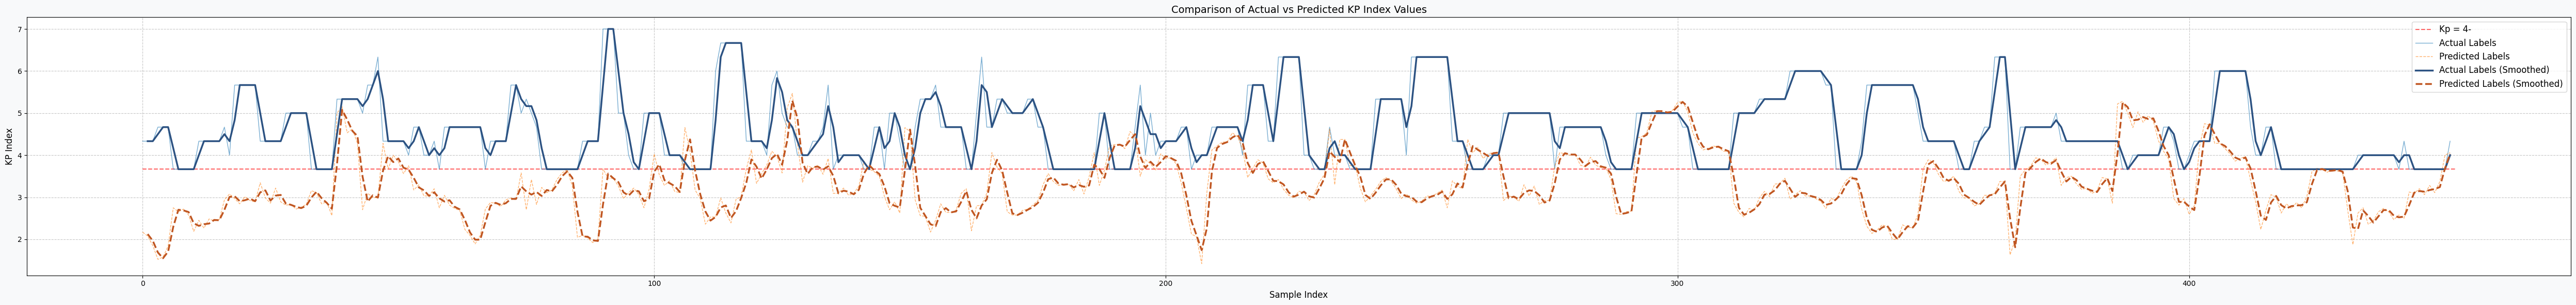

[2.171875, 2.078125, 1.8515625, 1.5234375, 1.578125, 1.84375, 2.75, 2.65625, 2.71875, 2.578125, 2.1875, 2.453125, 2.265625, 2.484375, 2.4375, 2.46875, 2.9375, 3.078125, 2.96875, 2.84375, 3.015625, 2.921875, 2.890625, 3.34375, 2.984375, 2.859375, 3.21875, 2.890625, 2.8125, 2.828125, 2.71875, 2.765625, 2.828125, 3.15625, 3.109375, 2.84375, 2.890625, 2.5625, 5.0, 5.15625, 4.53125, 4.625, 4.28125, 2.703125, 3.09375, 3.0, 2.984375, 4.28125, 3.671875, 4.0, 3.84375, 3.5625, 3.75, 3.171875, 3.296875, 3.03125, 3.03125, 3.203125, 2.75, 3.046875, 2.8125, 2.734375, 2.6875, 2.234375, 2.09375, 1.890625, 2.09375, 2.71875, 2.875, 2.859375, 2.78125, 2.9375, 2.984375, 2.9375, 3.578125, 2.703125, 3.421875, 2.828125, 3.234375, 3.109375, 3.171875, 3.421875, 3.578125, 3.65625, 3.265625, 2.046875, 2.09375, 2.03125, 1.921875, 2.0, 3.671875, 3.453125, 3.453125, 3.265625, 2.96875, 3.109375, 3.21875, 3.0625, 2.75, 3.1875, 4.03125, 3.53125, 3.28125, 3.390625, 3.140625, 3.109375, 4.65625, 4.09375, 3.171875, 2.9687

Training Progress: Epoch: 1:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  2.3763770513073785


Validation Progress: Epoch: 1:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.2706407691262243


Training Progress: Epoch: 2:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.6844226613278328


Validation Progress: Epoch: 2:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.0993866194227966


Training Progress: Epoch: 3:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.193000259467193


Validation Progress: Epoch: 3:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.164587894005136


Training Progress: Epoch: 4:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.812524290262324


Validation Progress: Epoch: 4:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.6720690076630986


Training Progress: Epoch: 5:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.6136286697466954


Validation Progress: Epoch: 5:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.5246725390286353


Training Progress: Epoch: 6:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.48129516452411975


Validation Progress: Epoch: 6:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.6102196544071194


Training Progress: Epoch: 7:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.40848630272255504


Validation Progress: Epoch: 7:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.739433759547431


Training Progress: Epoch: 8:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.32809051391492455


Validation Progress: Epoch: 8:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.648460735291433


Training Progress: Epoch: 9:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.28196085710699287


Validation Progress: Epoch: 9:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.608808769372038


Training Progress: Epoch: 10:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.26434503594858805


Validation Progress: Epoch: 10:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.4429920437044217


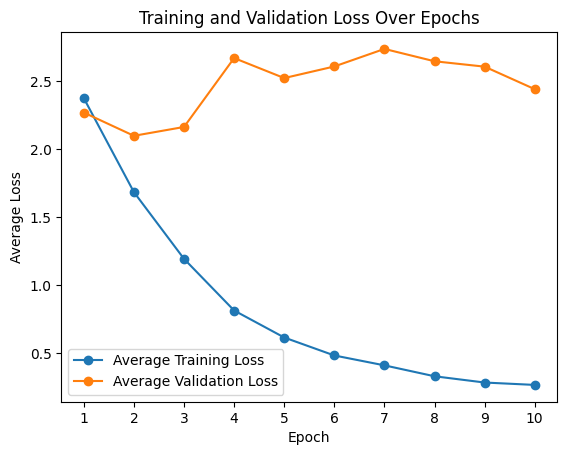

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/550 [00:00<?, ?it/s]

Average test loss: 2.4430
RMSE: 1.5630
MSE: 2.4404
MAE: 1.2681
R²: -0.2741
R: 0.0789
True Skill Score: 0.0690
Accuracy: 0.6115
Precision: 0.3180
Recall: 0.2778
F1 Score: 0.2965


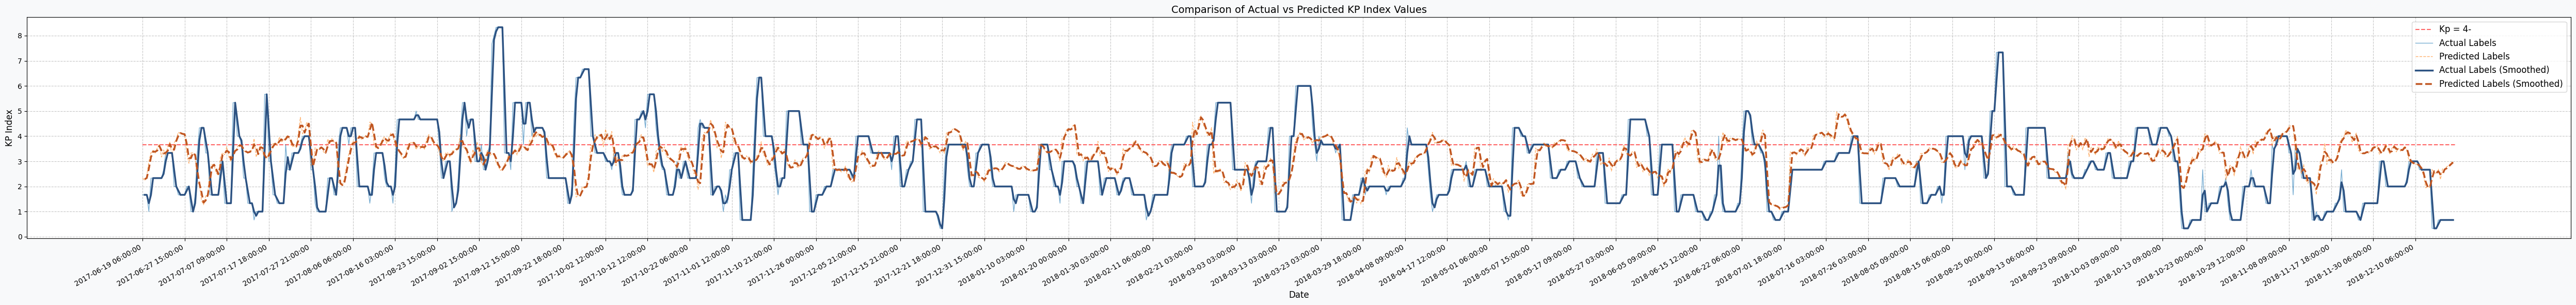

[2.34375, 2.234375, 2.4375, 2.984375, 3.34375, 3.4375, 3.328125, 3.53125, 3.6875, 3.171875, 3.453125, 3.234375, 3.609375, 3.765625, 3.1875, 3.734375, 3.875, 4.15625, 4.09375, 4.09375, 4.0625, 3.34375, 2.921875, 3.328125, 3.34375, 3.171875, 2.140625, 2.109375, 1.4375, 1.2734375, 1.6171875, 1.6953125, 2.6875, 2.875, 2.859375, 2.53125, 2.453125, 3.15625, 3.34375, 3.265625, 3.578125, 3.171875, 2.984375, 3.453125, 3.375, 3.5625, 3.6875, 3.5625, 3.421875, 3.375, 3.328125, 3.421875, 3.4375, 3.90625, 3.171875, 3.40625, 3.703125, 3.375, 3.125, 3.109375, 3.359375, 3.46875, 3.703125, 3.703125, 3.625, 3.96875, 3.78125, 3.8125, 3.953125, 4.03125, 3.859375, 3.578125, 3.609375, 3.5625, 4.09375, 4.75, 4.09375, 4.1875, 4.5625, 4.4375, 2.859375, 2.734375, 3.546875, 3.46875, 3.515625, 3.59375, 3.375, 3.3125, 3.890625, 3.71875, 3.90625, 3.765625, 3.71875, 2.171875, 2.09375, 2.015625, 2.359375, 2.84375, 3.28125, 3.640625, 3.796875, 3.703125, 3.921875, 4.03125, 3.875, 3.9375, 4.03125, 3.921875, 4.5625, 4.53

Testing Progress:   0%|          | 0/162 [00:00<?, ?it/s]

Average test loss: 2.8019
RMSE: 1.6739
MSE: 2.8019
MAE: 1.2639
R²: -2.2675
R: -0.0912


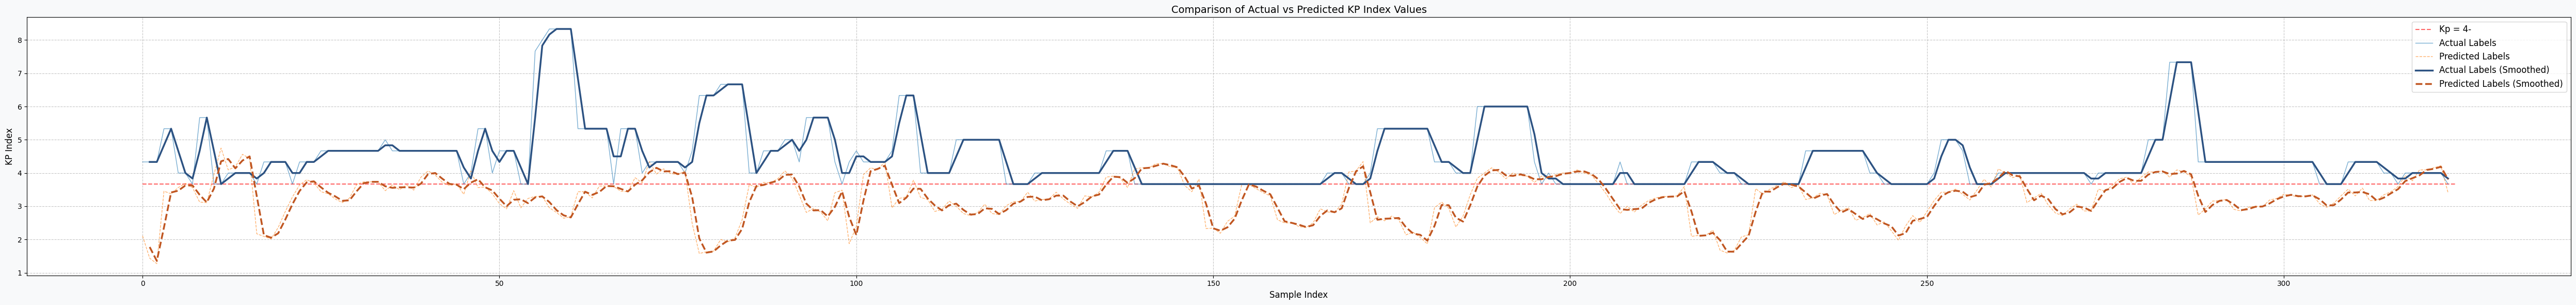

[2.109375, 1.4375, 1.2734375, 3.453125, 3.375, 3.5625, 3.6875, 3.5625, 3.125, 3.109375, 3.953125, 4.75, 4.09375, 4.1875, 4.5625, 4.4375, 2.171875, 2.09375, 2.015625, 2.359375, 2.84375, 3.28125, 3.640625, 3.796875, 3.703125, 3.4375, 3.375, 3.21875, 3.109375, 3.25, 3.65625, 3.734375, 3.734375, 3.734375, 3.46875, 3.640625, 3.5, 3.640625, 3.484375, 3.875, 4.0625, 3.9375, 3.71875, 3.625, 3.671875, 3.359375, 4.0625, 3.5625, 3.578125, 3.375, 3.078125, 2.921875, 3.46875, 2.953125, 3.234375, 3.296875, 3.296875, 2.953125, 2.8125, 2.640625, 2.6875, 3.4375, 3.4375, 3.25, 3.609375, 3.609375, 3.59375, 3.453125, 3.4375, 3.859375, 3.703125, 4.34375, 3.96875, 4.125, 3.984375, 3.953125, 4.0625, 2.484375, 1.578125, 1.6328125, 1.6484375, 2.0, 1.9296875, 2.046875, 2.59375, 3.65625, 3.5625, 3.71875, 3.703125, 3.828125, 4.0625, 3.84375, 3.34375, 2.8125, 2.9375, 2.828125, 2.5625, 3.40625, 3.484375, 1.875, 2.390625, 3.953125, 4.15625, 4.09375, 4.34375, 2.953125, 3.234375, 3.28125, 3.78125, 3.265625, 3.203125, 

In [10]:

total_avg_test_loss = 0
total_rmse = 0
total_mse = 0
total_mae = 0
total_r2 = 0
total_r = 0
total_tts = 0
total_accuracy = 0
total_precision = 0
total_recall = 0
total_f1 = 0

active_total_avg_test_loss = 0
active_total_rmse = 0
active_total_mse = 0
active_total_mae = 0
active_total_r2 = 0
active_total_r = 0


for i in range(k_folds):
    print(f'FOLD {i + 1}')
    print('--------------------------------')
    test_indices = dataloaders[i]
    active_test_indices = active_dataloaders[i]
    train_indices = []
    for j in range(k_folds):
        if j != i:
            train_indices += dataloaders[j]

    trainloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=20, prefetch_factor=6, pin_memory=True)
    testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
    active_testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, active_test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
    trainloader = fabric.setup_dataloaders(trainloader)
    testloader = fabric.setup_dataloaders(testloader)
    active_testloader = fabric.setup_dataloaders(active_testloader)


    # Reinitialize model
    model = GmiSwinTransformer(hidden_size=hidden_size)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    model, optimizer = fabric.setup(model, optimizer)
    model.train()

    # Training the model
    n_total_steps = len(trainloader)
    avg_train_loss_over_epochs = []
    avg_val_loss_over_epochs = []

    for epoch in range(num_epochs):
        train_losses = []
        val_losses = []

        # Training loop
        model.train()
        for i, (images, labels) in tqdm(enumerate(trainloader), desc=f"Training Progress: Epoch: {epoch + 1}", total=len(trainloader)):
            # Move images and labels to device
            images = images.float()
            labels = labels.float()

            # Forward pass with autograd
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            # tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

            # Backward pass and optimization
            optimizer.zero_grad()
            fabric.backward(loss)
            optimizer.step()
            # Store the loss
            train_losses.append(loss.item())

        # Store the average training loss for this epoch
        avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
        print("Average Training Loss: ", sum(train_losses) / len(train_losses))

        # Validation loop
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(testloader, desc=f"Validation Progress: Epoch: {epoch + 1}", total=len(testloader)):
                images = images.float()
                # images = images.permute(1, 0, 2, 3, 4)
                labels = labels.float()
                outputs = model(images).squeeze(1)
                loss = criterion(outputs, labels)
                # print("Validation Loss: ", loss.item())
                val_losses.append(loss.item())

        # Store the average validation loss for this epoch
        avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))
        print("Average Validation Loss: ", sum(val_losses) / len(val_losses))

    # Plot loss over epochs
    plt.figure()
    plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
    plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.title('Training and Validation Loss Over Epochs')
    plt.show()

    test_losses = []
    all_labels = []
    all_outputs = []

    model.eval()

    print('--------------------------------')
    print('Test for Full set')
    print('--------------------------------')

# Test for Full set
    with torch.no_grad():
        for images, labels in tqdm(testloader, desc="Testing Progress"):
            images = images.float()
            # images = images.permute(1, 0, 2, 3, 4)
            labels = labels.float()
            # print("Label: ", labels)
            outputs = model(images).squeeze(1)
            # print("Output: ", outputs)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    avg_test_loss = sum(test_losses) / len(test_losses)
    rmse = math.sqrt(avg_test_loss)
    mse = mean_squared_error(all_labels, all_outputs)
    mae = mean_absolute_error(all_labels, all_outputs)
    r2 = r2_score(all_labels, all_outputs)
    r, _ = stats.pearsonr(all_labels, all_outputs)
    tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
    accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
    tts = true_skill_score(tp, tn, fp, fn)



    # Accumulate metrics for averaging across folds
    total_avg_test_loss += avg_test_loss
    total_rmse += rmse
    total_mse += mse
    total_mae += mae
    total_r2 += r2
    total_r += r
    total_tts += tts
    total_accuracy += accuracy
    total_precision += precision
    total_recall += recall
    total_f1 += f1


    print(f'Average test loss: {avg_test_loss:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R²: {r2:.4f}')
    print(f'R: {r:.4f}')
    print(f'True Skill Score: {tts:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    test_dates = list(kp_dates_list[i] for i in test_indices)
    # Convert to pandas Series for easy rolling average calculation
    labels_series = pd.Series(all_labels)
    outputs_series = pd.Series(all_outputs)

    # Calculate rolling averages with window size of 5
    window_size = 2
    labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
    outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

    # Create a better-looking plot
    plt.figure(figsize=(50, 6), facecolor='#f8f9fa')
    plt.plot([0, len(test_dates)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')
    # Plot original data with thin lines
    plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
    plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

    # Plot smoothed data with thicker lines
    plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
    plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

    # Format x-axis with dates
    test_dates_sliced = test_dates[0:len(all_labels):20]
    plt.xticks(range(0, len(test_dates), 20), test_dates_sliced, rotation=30, ha='right')

    # Better grid styling
    plt.grid(True, linestyle='--', alpha=0.7)

    # Improve labels and title
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('KP Index', fontsize=12)
    plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

    # Better legend
    plt.legend(loc='best', frameon=True, fontsize=12)

    # Adjust layout for better spacing
    plt.tight_layout()

    plt.show()
    print(all_outputs)

    print('--------------------------------')
    print('Test for Active Periods')
    print('--------------------------------')

    test_losses = []
    all_labels = []
    all_outputs = []

# Test for active periods
    with torch.no_grad():
        for images, labels in tqdm(active_testloader, desc="Testing Progress"):
            images = images.float()
            labels = labels.float()
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    avg_test_loss = sum(test_losses) / len(test_losses)
    rmse = math.sqrt(avg_test_loss)
    mse = mean_squared_error(all_labels, all_outputs)
    mae = mean_absolute_error(all_labels, all_outputs)
    r2 = r2_score(all_labels, all_outputs)
    r, _ = stats.pearsonr(all_labels, all_outputs)

    # Accumulate metrics for averaging across folds
    active_total_avg_test_loss += avg_test_loss
    active_total_rmse += rmse
    active_total_mse += mse
    active_total_mae += mae
    active_total_r2 += r2
    active_total_r += r

    print(f'Average test loss: {avg_test_loss:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R²: {r2:.4f}')
    print(f'R: {r:.4f}')

    # Convert to pandas Series for easy rolling average calculation
    labels_series = pd.Series(all_labels)
    outputs_series = pd.Series(all_outputs)

    # Calculate rolling averages with a window size of 5
    window_size = 2
    labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
    outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

    # Create a better-looking plot
    plt.figure(figsize=(50, 6), facecolor='#f8f9fa')

    plt.plot([0, len(all_labels)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')

    # Plot original data with thin lines
    plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
    plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

    # Plot smoothed data with thicker lines
    plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
    plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

    # Better grid styling
    plt.grid(True, linestyle='--', alpha=0.7)

    # Improve labels and title
    plt.xlabel('Sample Index', fontsize=12)
    plt.ylabel('KP Index', fontsize=12)
    plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

    # Better legend
    plt.legend(loc='best', frameon=True, fontsize=12)

    # Adjust layout for better spacing
    plt.tight_layout()

    plt.show()
    print(all_outputs)


print('--------------------------------')
print('Metrics for Full Set')
print('--------------------------------')

# Average metrics across all folds
total_avg_test_loss /= k_folds
total_rmse /= k_folds
total_mse /= k_folds
total_mae /= k_folds
total_r2 /= k_folds
total_r /= k_folds
total_tts /= k_folds
total_accuracy /= k_folds
total_precision /= k_folds
total_recall /= k_folds
total_f1 /= k_folds

print(f'Average test loss across all folds: {total_avg_test_loss:.4f}')
print(f'Average RMSE across all folds: {total_rmse:.4f}')
print(f'Average MSE across all folds: {total_mse:.4f}')
print(f'Average MAE across all folds: {total_mae:.4f}')
print(f'Average R² across all folds: {total_r2:.4f}')
print(f'Average R across all folds: {total_r:.4f}')
print(f'Average active R across all folds: {active_total_r:.4f}')
print(f'Average True Skill Score across all folds: {total_tts:.4f}')
print(f'Average Accuracy across all folds: {total_accuracy:.4f}')
print(f'Average Precision across all folds: {total_precision:.4f}')
print(f'Average Recall across all folds: {total_recall:.4f}')
print(f'Average F1 Score across all folds: {total_f1:.4f}')

print('--------------------------------')
print('Metrics for Active Periods')
print('--------------------------------')
# Average metrics across all folds
active_total_avg_test_loss /= k_folds
active_total_rmse /= k_folds
active_total_mse /= k_folds
active_total_mae /= k_folds
active_total_r2 /= k_folds
active_total_r /= k_folds

print(f'Average active test loss across all folds: {active_total_avg_test_loss:.4f}')
print(f'Average active RMSE across all folds: {active_total_rmse:.4f}')
print(f'Average active MSE across all folds: {active_total_mse:.4f}')
print(f'Average active MAE across all folds: {active_total_mae:.4f}')
print(f'Average active R² across all folds: {active_total_r2:.4f}')
print(f'Average active R across all folds: {active_total_r:.4f}')


